<a href="https://colab.research.google.com/github/Baraa-Rayed/ECG-Arrhythmia-Classification/blob/main/ECG_with_spectogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install wfdb wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 KB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=722da3fa8f7a67014596befdd0f40613e60f0d5f77d3015e23098767369ad5c4
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
  Attempting uninstall: SoundFile
    Found existing installation: soundfile 0.12.1
    Uninstalling soundfile-0.12.1:
      Successfully uninstalled soundfile-0.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.


In [ ]:
import glob
import wfdb
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [ ]:
import os
import wfdb
wfdb.dl_database('mitdb', os.path.join(os.getcwd(), 'mitdb'))

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [ ]:
import numpy as np
import os
import wfdb
import librosa
import glob
from scipy.signal import spectrogram

# Load ECG data and annotations
ecg_path = glob.glob('/content/mitdb/*.hea')
for i in list(ecg_path):
    record = wfdb.rdrecord(f'{i[:-4]}')
    signal = record.p_signal[:,0]
    annotations = wfdb.rdann(f'{i[:-4]}', 'atr')

    # Define the classes and mapping from annotations to classes
    classes = {
        'N': 0, # Normal beat
        'L': 1, # Left bundle branch block beat
        'R': 2, # Right bundle branch block beat
        'V': 3, # Premature ventricular contraction
        'A': 4 # APB (Atrial premature beat)
    }
    ann2class = {ann: classes.get(ann, 4) for ann in annotations.symbol}

    # Create folders for each class
    data_save_path = '/content/drive/MyDrive/mitdb_data2/'
    for cls in classes:
        folder_path = os.path.join(data_save_path, f"{cls}_segments")
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        folder_path = os.path.join(data_save_path, f"{cls}_spectrograms")
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

    # Preprocess the ECG data
    signal_filt = librosa.effects.preemphasis(signal)
    signal_filt = librosa.effects.trim(signal_filt)[0]
    signal_filt = librosa.util.normalize(signal_filt)

    # Divide the signal into smaller segments and label each segment
    window_size = 2 * record.fs
    step_size = int(0.5 * window_size)
    segments = librosa.util.frame(signal_filt, frame_length=window_size, hop_length=step_size)
    beat_indices = annotations.sample[np.logical_and(annotations.sample >= window_size//2,
                                                      annotations.sample < len(signal_filt) - window_size//2)]
    labels = [ann2class[annotations.symbol[np.argmax(annotations.sample == beat_idx)]] for beat_idx in beat_indices]
    segment_labels = [labels[np.argmax(beat_indices <= seg.mean())] for seg in segments.T]

    class2ann = {
        0: 'N',
        1: 'L',
        2: 'R',
        3: 'V',
        4: 'A'
    }

    # Save segments and spectrograms to their respective class folders
    for i, seg in enumerate(segments.T):
        label = segment_labels[i]
        cls = class2ann[label]
        seg_file_path = os.path.join(data_save_path, f"{cls}_segments", f"{cls}_segment_{i}.npy")
        np.save(seg_file_path, seg)
        f, t, Sxx = spectrogram(seg, fs=record.fs)
        spec_file_path = os.path.join(data_save_path, f"{cls}_spectrograms", f"{cls}_spectrogram_{i}.npy")
        np.save(spec_file_path, Sxx)



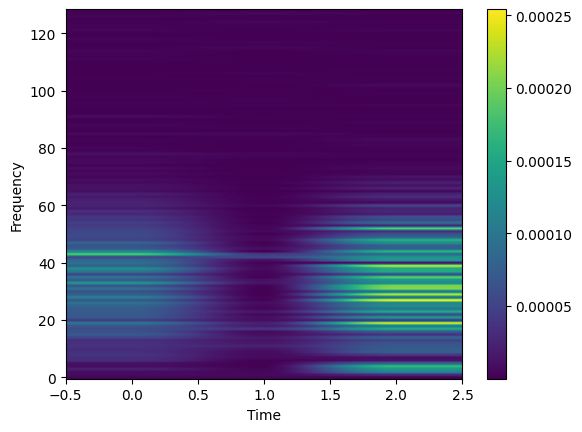

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the .npy file
spec = np.load('/content/drive/MyDrive/mitdb_data2/A_spectrograms/A_spectrogram_113.npy')

# Plot the spectrogram
plt.imshow(spec, cmap='viridis', origin='lower', aspect='auto')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()


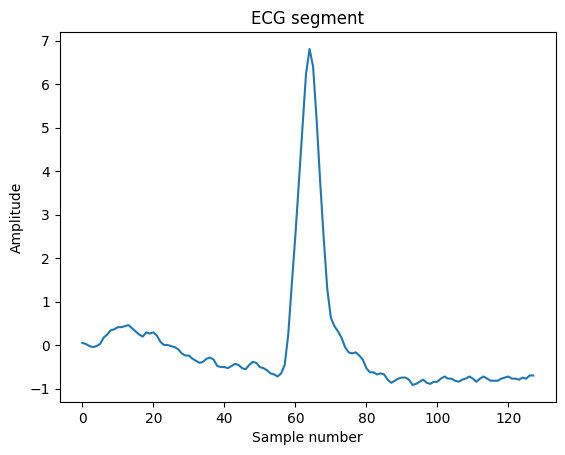

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load ECG segment from npy file
segment = np.load('/content/drive/MyDrive/mitdb_data/1D/101/MLII/N/1032.npy')

# Plot ECG segment
plt.plot(segment)
plt.xlabel('Sample number')
plt.ylabel('Amplitude')
plt.title('ECG segment')
plt.show()
